In [1]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors, Word2Vec
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import itertools
import sys
from utils import filter_terms, create_target_sets, create_attribute_sets, load_specifications, load_embedding_dict, CreateSlice, CreateCorpus
from plot_utils import set_size
from sklearn.decomposition import PCA

sys.path.append('./evaluation')
from projections import SubspaceProjections, TARGETS_CHRISTIAN, TARGETS_JEWISH

### Global plotting parameters

In [2]:
TEX_FONTS = {
    # Use LaTeX to write all text
    "text.usetex": False,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 6,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6
}
# Figure height and width
WIDTH = 360
FIG_DIM = set_size(WIDTH)
plt.rcParams.update(TEX_FONTS)

WIDTH = 360
FIG_DIM = set_size(WIDTH)

colourWheel =['#329932',
            '#ff6961',
            'b',
            '#6a3d9a',
            '#fb9a99',
            '#e31a1c',
            '#fdbf6f',
            '#ff7f00',
            '#cab2d6',
            '#6a3d9a',
            '#ffff99',
            '#b15928',
            '#67001f',
            '#b2182b',
            '#d6604d',
            '#f4a582',
            '#fddbc7',
            '#f7f7f7',
            '#d1e5f0',
            '#92c5de',
            '#4393c3',
            '#2166ac',
            '#053061']

## 1) Plot average and total words over slices

In [3]:
# Put word statistics of a corpus into a dictionary 
def word_stats_dictionary(corpus):
    words_per_session = np.array([sum([len(sent.split()) for sent in v]) for v in corpus])
    word_stats_dict = {
                       'total_words' : words_per_session.sum(),   
                       'avg' : round(words_per_session.mean()),
                       'std' : round(words_per_session.std()),
                       'max' : round(words_per_session.max()),
                       'min' : round(words_per_session.min()),
                       'lower percentile' : round(np.percentile(words_per_session,25)),
                       'median' : round(np.percentile(words_per_session,50)),
                       'upper percentile' :round(np.percentile(words_per_session,75))
                      }
    return word_stats_dict

#### Get statistics for processed Reichstag historic slices 

In [4]:
reichstag_processed = {}
historic_periods =  ['kaiserreich_1', 'kaiserreich_2', 'weimar', 'ns']
for period in historic_periods:
    corpus = list(CreateSlice(f'reichstag/{period}_processed/', profiling=True))
    reichstag_processed[period] = word_stats_dictionary(corpus)

reichstag_processed = pd.DataFrame(reichstag_processed).T

#### Get statistics for processed Bundestag historic slices 

In [6]:
bundestag_slices_processed = {}
bundestag_historic_periods = ['cdu_1', 'spd_1', 'cdu_2', 'spd_2', 'cdu_3']
for period in bundestag_historic_periods:
    corpus = list(CreateCorpus(f'bundestag/{period}', profiling=True))
    bundestag_slices_processed[period] = word_stats_dictionary(corpus)
bundestag_slices_processed = pd.DataFrame(bundestag_slices_processed).T
# index = [f'bt_{i}' for i in range(1,len(bundestag_slices_processed)+1)]
# bundestag_slices_processed.set_index(np.array(bundestag_historic_periods), inplace=True)
bundestag_slices_processed

,total_words,avg,std,max,min,lower percentile,median,upper percentile
cdu_1,43337027.0,38625.0,21194.0,119438.0,144.0,23198.0,36178.0,52626.0
spd_1,35208879.0,42420.0,29564.0,119176.0,119.0,15290.0,33842.0,69765.0
cdu_2,55451433.0,56410.0,33591.0,144753.0,211.0,28644.0,44944.0,89752.0
spd_2,28634660.0,65079.0,35246.0,144768.0,177.0,35784.0,54506.0,101390.0
cdu_3,66141710.0,74736.0,48944.0,652314.0,2166.0,38241.0,59639.0,105477.0


#### Merge both frames

In [15]:
all_slices_processed = reichstag_processed.append(bundestag_slices_processed)

#### Plot total and average words

In [16]:
plt.style.use('seaborn-white')

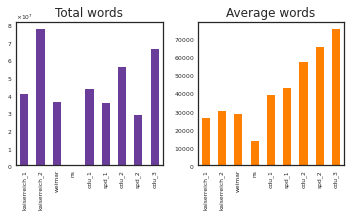

In [17]:
FIG_DIM = set_size(WIDTH, subplots=(1,2))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=FIG_DIM)
all_slices_processed[['total_words']].plot.bar(rot=90, color=colourWheel[3], ax=ax1, title='Total words')
all_slices_processed[['avg']].plot.bar(rot=90,color=colourWheel[7], ax=ax2, title='Average words')

# ax1.set_xlabel('slice')
# ax2.set_xlabel('slice')
ax1.yaxis.major.formatter._useMathText = True
ax2.yaxis.major.formatter._useMathText = True
ax1.get_legend().remove()
ax2.get_legend().remove()
fig.set_size_inches(FIG_DIM[0], (FIG_DIM[0]/1.6))
plt.tight_layout()
plt.savefig('plots/total_and_avg_words_submission.svg', format='svg', dpi=300)
plt.show()

## 2) Plot average RIPA values over historic slices

The average RIPA values are plotted over several slice at once. For this a function to initialise a SubspaceProjection object, the set of all attribute terms present in a slice, plus the bias subspace, is created

In [10]:
def set_up(embedding_vocab, embedding_vectors, protocol_type):
    
    ripaObject = SubspaceProjections()
    embd_dict = load_embedding_dict(embedding_vocab, embedding_vectors, glove=False)
    ripaObject.set_embd_dict(embd_dict)
    # Load attribute sets
    attribute_sets = create_attribute_sets(embd_dict, protocol_type)
    # The vocab is composed of all target and attribute terms
    vocab = TARGETS_CHRISTIAN + TARGETS_JEWISH + list(dict.fromkeys(list(itertools.chain.from_iterable(attribute_sets.values()))))
    
    ripaObject._build_vocab_dict(vocab)
    ripaObject._build_embedding_matrix()
    race_direction_pca = ripaObject.doPCA(TARGETS_CHRISTIAN, TARGETS_JEWISH, plot=False)
    
    return ripaObject, attribute_sets, race_direction_pca

In [11]:
# Set-up for all Reichstag slices
ks_1, ks_1_attributes, ks_1_subspace = set_up('data/vocab/kaiserreich_1.json', 'models/kaiserreich_1.vectors.npy', 'RT')
ks_2, ks_2_attributes, ks_2_subspace = set_up('data/vocab/kaiserreich_2.json', 'models/kaiserreich_2.vectors.npy', 'RT')
weimar, weimar_attributes, weimar_subspace = set_up('data/vocab/weimar.json', 'models/weimar.vectors.npy', 'RT')

In [12]:
# Set-up for all Bundestag slices
cdu_1, cdu_1_attributes, cdu_1_subspace = set_up('data/vocab/cdu_1.json', 'models/cdu_1.vectors.npy', 'BRD')
spd_1, spd_1_attributes, spd_1_subspace = set_up('data/vocab/spd_1.json', 'models/spd_1.vectors.npy', 'BRD')
cdu_2, cdu_2_attributes, cdu_2_subspace = set_up('data/vocab/cdu_2.json', 'models/cdu_2.vectors.npy', 'BRD')
spd_2, spd_2_attributes, spd_2_subspace = set_up('data/vocab/spd_2.json', 'models/spd_2.vectors.npy', 'BRD')
cdu_3, cdu_3_attributes, cdu_3_subspace = set_up('data/vocab/cdu_3.json', 'models/cdu_3.vectors.npy', 'BRD')

In [18]:
# We want to iterate over all the models 
all_ripa = [ks_1, ks_2, weimar]
all_attributes = {k:[v, ks_2_attributes[k], weimar_attributes[k]] for k,v in ks_1_attributes.items()}
all_subspaces = [ks_1_subspace, ks_2_subspace, weimar_subspace]
corpora_rt = ['kaiserreich_1', 'kaiserreich_2', 'weimar']

In [19]:
# We want to iterate over all the models 
all_ripa_brd = [cdu_1, spd_1, cdu_2, spd_2, cdu_3]
all_attributes_brd = {k:[v, spd_1_attributes[k], cdu_2_attributes[k], spd_2_attributes[k], cdu_3_attributes[k]] for k,v in cdu_1_attributes.items()}
all_subspaces_brd = [cdu_1_subspace, spd_1_subspace, cdu_2_subspace, spd_2_subspace, cdu_3_subspace]
corpora_brd = ['cdu_1', 'spd_1', 'cdu_2', 'spd_2', 'cdu_3']

### Create a dataframe that shows average RIPA values and can be used for plotting

In [20]:
# Output a dataframe containing RIPA values across slices and semantic domains
def all_scores(ripa, atts, subspaces, corpora_names):
    all_scores = {}
    for att in atts:
        scores_for_attribute = []
        for i in range(len(ripa)):
            projections = ripa[i].get_projections(atts[att][i], subspaces[i], corpora_names[i])
            scores_for_attribute.append(list(projections.values()))
        all_scores[att] = scores_for_attribute
    return all_scores

In [21]:
ripa_rt = all_scores(all_ripa, all_attributes, all_subspaces, corpora_rt)

In [22]:
ripa_brd = all_scores(all_ripa_brd, all_attributes_brd, all_subspaces_brd, corpora_brd)

In [23]:
def get_avg_ripa_df(scores, protocol_type, corpora_names):
    """Output a dataframe holding average RIPA values"""
#     if protocol_type == 'RT':
#         index = corpora_names
#     elif protocol_type == 'BRD':
#         index = ['full_BRD','CDU_I', 'SPD_I', 'CDU_II', 'SPD_II', 'CDU_III']
    df = pd.DataFrame(scores, index=corpora_names).applymap(np.mean)
    return df

In [24]:
avg_bias_rt = get_avg_ripa_df(ripa_rt, 'RT', corpora_rt)
avg_bias_rt

,sentiment_pro,sentiment_con,economic_pro,economic_con,conspiratorial_pro,conspiratorial_con,religious_pro,religious_con,racist_pro,racist_con,ethic_pro,ethic_con,patriotic_pro,patriotic_con
kaiserreich_1,0.044598,-0.043136,-0.087549,-0.107920,0.050418,-0.037777,0.105858,-0.005435,0.077588,-0.103101,0.116825,-0.068078,0.023463,-0.116190
kaiserreich_2,0.047203,-0.023807,0.069590,-0.049577,0.039731,-0.070677,0.122630,0.087565,0.041611,-0.079105,0.085626,-0.046772,0.071318,-0.035184
weimar,0.080702,-0.003454,0.068368,-0.058097,0.088591,-0.105918,0.181655,0.060710,0.048060,-0.047311,0.173108,0.002259,0.091866,-0.055953


In [25]:
avg_bias_brd = get_avg_ripa_df(ripa_brd, 'BRD', corpora_brd)
avg_bias_brd

,sentiment_pro,sentiment_con,economic_pro,economic_con,conspiratorial_pro,conspiratorial_con,religious_pro,religious_con,racist_pro,racist_con,ethic_pro,ethic_con,patriotic_pro,patriotic_con
cdu_1,-0.072234,0.037179,0.011301,0.029223,-0.042315,0.014124,-0.127555,0.006124,-0.091918,0.048045,-0.097256,0.016516,0.047093,0.124857
spd_1,0.041490,-0.088253,-0.032811,-0.035294,0.016075,0.024669,0.020227,-0.076848,0.082405,0.034229,0.134781,0.009171,-0.043988,-0.104350
cdu_2,0.052957,-0.075171,0.030368,0.041282,0.039323,0.012039,0.063760,0.032041,0.106044,-0.013024,0.122102,0.076192,-0.061436,-0.088239
spd_2,0.040291,0.027196,0.033881,0.042531,0.041941,0.046104,0.048104,-0.011166,0.121067,0.026302,0.127965,0.103474,-0.008400,0.048351
cdu_3,-0.010230,0.049091,0.011782,-0.018193,-0.002013,0.009600,0.016185,-0.023372,-0.056984,-0.015602,-0.079460,-0.013689,0.029341,0.038881


In [26]:
full = avg_bias_rt.append(avg_bias_brd)

In [31]:
DIMS = ['sentiment', 'patriotic', 'economic', 'conspiratorial', 'racist', 'religious', 'ethic']
MULTI_COLUMNS = pd.MultiIndex.from_product([DIMS, ['pro', 'con']])

def plot_avg_bias(bias_df, corpora_names, save=True, path_to_save=None):
    # Create multi-index column for each attribute dimension to juxtapose pro and neg aspects of each dimension
    bipolar_df = pd.DataFrame(index=bias_df.index, columns= MULTI_COLUMNS)
    for dim in DIMS:
        bipolar_df.loc[:, (dim, 'pro')] = bias_df.loc[:,f'{dim}_pro']
        bipolar_df.loc[:, (dim, 'con')] = bias_df.loc[:,f'{dim}_con']

    # Create the barplot showing average bias over time
    fig = plt.figure(figsize=(FIG_DIM))

    for dim,num in zip(DIMS, range(1,len(DIMS)+1)):
        ax = fig.add_subplot(3,3,num)
        bipolar_df.plot(y=[dim],kind='bar', stacked=False, ax=ax, legend=False, use_index=True)
        ax.set_title(dim)
        ax.set_xticklabels(corpora_names)
        ax.yaxis.major.formatter._useMathText = True
        # ax.get_legend().remove()
#         fig.set_size_inches(FIG_DIM[0], (FIG_DIM[0]/0.8))
        for ax in fig.get_axes():
            ax.label_outer()
            ax.set_ylim(bipolar_df.values.min() - 0.05, bipolar_df.values.max() + 0.05)
    fig.legend(['positive', 'negative'], loc= 'lower right')
    plt.tight_layout()
    if save:
        plt.savefig(f'plots/{path_to_save}.pdf', dpi=300)    
    plt.show()

In [33]:
x_labels = ['KS_I', 'KS_II', 'Weimar']

/home/twalter/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


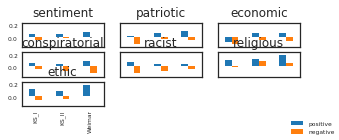

In [34]:
plot_avg_bias(avg_bias_rt, x_labels, save=False, path_to_save='avg_ripa_whole_period')

In [25]:
x_labels = ['KS_I', 'KS_II', 'Weimar']
plot_avg_bias(full, x_labels + corpora_brd, save=True, path_to_save='avg_ripa_whole_period_4by2')

In [37]:
full

,sentiment_pro,sentiment_con,economic_pro,economic_con,conspiratorial_pro,conspiratorial_con,religious_pro,religious_con,racist_pro,racist_con,ethic_pro,ethic_con,patriotic_pro,patriotic_con
kaiserreich_1,0.044598,-0.043136,-0.087549,-0.107920,0.050418,-0.037777,0.105858,-0.005435,0.077588,-0.103101,0.116825,-0.068078,0.023463,-0.116190
kaiserreich_2,0.047203,-0.023807,0.069590,-0.049577,0.039731,-0.070677,0.122630,0.087565,0.041611,-0.079105,0.085626,-0.046772,0.071318,-0.035184
weimar,0.080702,-0.003454,0.068368,-0.058097,0.088591,-0.105918,0.181655,0.060710,0.048060,-0.047311,0.173108,0.002259,0.091866,-0.055953
cdu_1,-0.072234,0.037179,0.011301,0.029223,-0.042315,0.014124,-0.127555,0.006124,-0.091918,0.048045,-0.097256,0.016516,0.047093,0.124857
spd_1,0.041490,-0.088253,-0.032811,-0.035294,0.016075,0.024669,0.020227,-0.076848,0.082405,0.034229,0.134781,0.009171,-0.043988,-0.104350
cdu_2,0.052957,-0.075171,0.030368,0.041282,0.039323,0.012039,0.063760,0.032041,0.106044,-0.013024,0.122102,0.076192,-0.061436,-0.088239
spd_2,0.040291,0.027196,0.033881,0.042531,0.041941,0.046104,0.048104,-0.011166,0.121067,0.026302,0.127965,0.103474,-0.008400,0.048351
cdu_3,-0.010230,0.049091,0.011782,-0.018193,-0.002013,0.009600,0.016185,-0.023372,-0.056984,-0.015602,-0.079460,-0.013689,0.029341,0.038881
